Looking at the HST data for GJ 699.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import astropy.io.fits as fits
import os
from scipy.io.idl import readsav
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.modeling import models, fitting
from craftroom import resample
from scipy.interpolate import interp1d
from astropy.convolution import convolve, Box1DKernel



%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [2]:
path = '/home/david/work/muscles/MegaMUSCLES/GJ_699/HST/STIS/'

In [5]:
x1ds =  glob.glob(path+'*x1d.fits')

for x in x1ds:
    hdr = fits.getheader(x,0)
    print(hdr['ROOTNAME'], hdr['OPT_ELEM'])

odlm24020 G230L
odlm22030 G140L
odlm24030 G140M
odlm24040 G140M
odlm22010 G140L
odlm22020 G140L
odlm24050 G140M


In [8]:
"""for x in x1ds:
    hdr = fits.getheader(x,0)
    print(hdr['ROOTNAME'], hdr['OPT_ELEM'])
    data = fits.getdata(x,1)[0]
    plt.step(data['WAVELENGTH'], data['FLUX'], where='mid')
    plt.step(data['WAVELENGTH'], data['ERROR'], where='mid')
    plt.show()"""

"for x in x1ds:\n    hdr = fits.getheader(x,0)\n    print(hdr['ROOTNAME'], hdr['OPT_ELEM'])\n    data = fits.getdata(x,1)[0]\n    plt.step(data['WAVELENGTH'], data['FLUX'], where='mid')\n    plt.step(data['WAVELENGTH'], data['ERROR'], where='mid')\n    plt.show()"

Checking notes, I've already processed the G140L and G140M data:

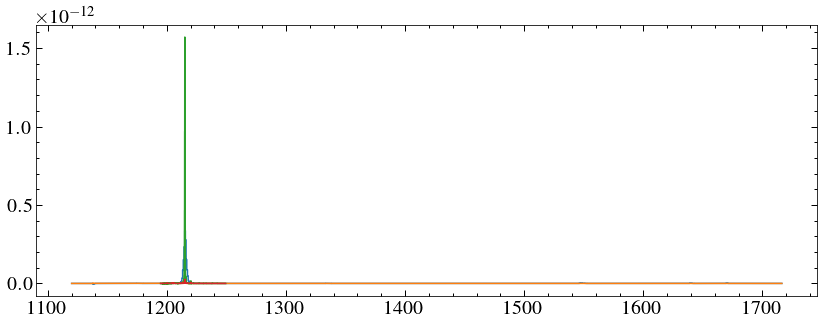

In [53]:
fuv = glob.glob('STIS/*140*ecsv')
for sp in fuv:
    data = Table.read(sp)
    plt.step(data['WAVELENGTH'], data['FLUX'], where='mid')
    plt.step(data['WAVELENGTH'], data['ERROR'], where='mid')
fdata = Table.read(fuv[0])    

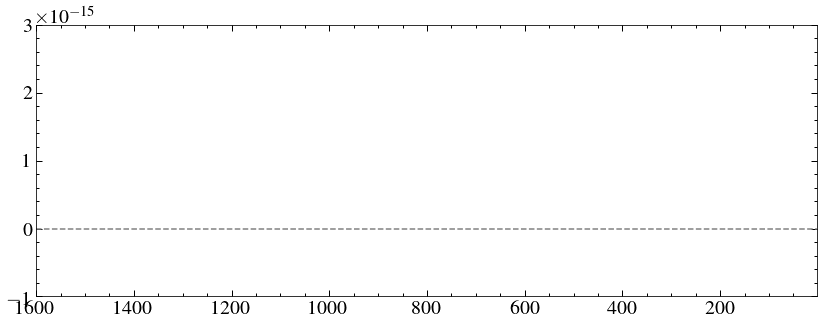

In [66]:
nuv = '/home/david/work/muscles/MegaMUSCLES/GJ_699/HST/STIS/odlm24020_x1d.fits'
ndata = fits.getdata(nuv,1)[0]
w, f, e, dq = ndata['WAVELENGTH'], ndata['FLUX'], ndata['ERROR'], ndata['DQ']  
#smooth = 2
#f = convolve(f,Box1DKernel(smooth))
#e = convolve(e,Box1DKernel(smooth))/(smooth**0.5)

#plt.step(w, f, where='mid')
#plt.step(w, e, where='mid')
#plt.step(w[dq==0], f[dq==0], where='mid')

plt.xlim(1600)
plt.ylim(-0.1e-14, 3e-15)
plt.axhline(0, ls='--', c='0.5')

Ok, looks like no useful overlap with the fuv data. What about galex- no Galex photometry available. G430L?

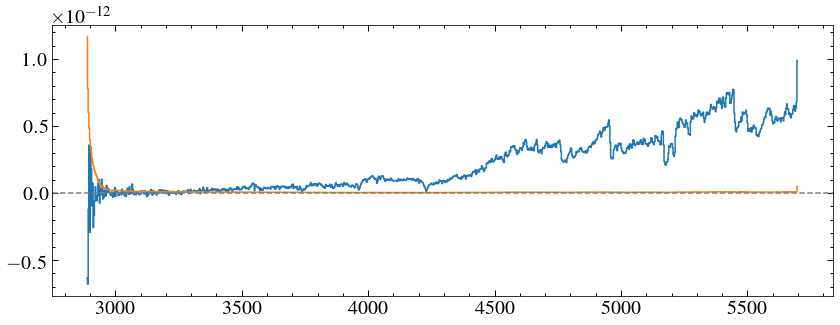

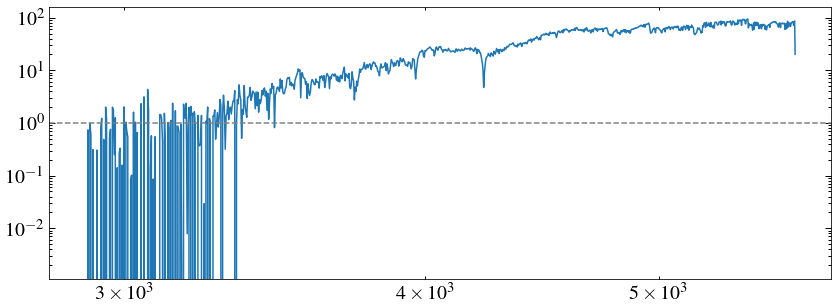

In [49]:
g430lpath = glob.glob(path+'*sx1.fits')
odata = fits.getdata(g430lpath[0],1)[0]
plt.step(odata['WAVELENGTH'], odata['FLUX'], where='mid')
plt.step(odata['WAVELENGTH'], odata['ERROR'], where='mid')
plt.axhline(0, ls='--', c='0.5')
plt.show()
plt.plot(odata['WAVELENGTH'], odata['FLUX']/odata['ERROR'])
plt.axhline(1, ls='--', c='0.5')
plt.xscale('log')
plt.yscale('log')
#ca =[ 3933.6614, 3968.4673] #no ca detected
#[plt.axvline(line, c='r') for line in ca]
#plt.xlim(3900, 4100)
#plt.ylim(-0.1e-12, 0.1e-12)


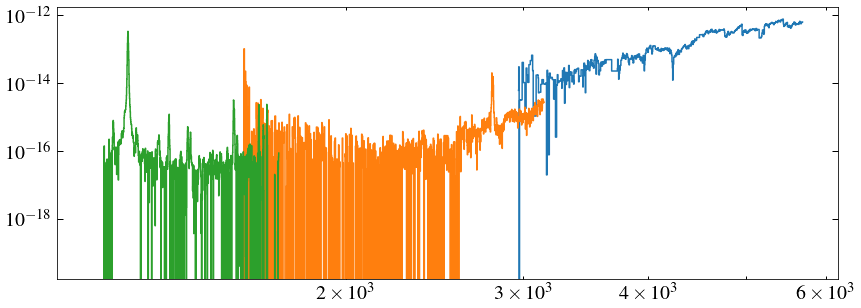

In [102]:
plt.step(odata['WAVELENGTH'][odata['DQ']==0], odata['FLUX'][odata['DQ']==0], where='mid')
plt.step(ndata['WAVELENGTH'][ndata['DQ']==0], ndata['FLUX'][ndata['DQ']==0], where='mid')
plt.step(fdata['WAVELENGTH'], fdata['FLUX'], where='mid')
plt.axhline(0, ls='--', c='0.5')
plt.xscale('log')
plt.yscale('log')
#print(ndata['WAVELENGTH'][-1], odata['WAVELENGTH'][0])
#plt.xlim(1550,1800 )



FUV v NUV

9.496036710588472e-15 5.448265006014494e-16
2.1043271135965537e-14 1.2242087843536537e-14
0.45126238450440237


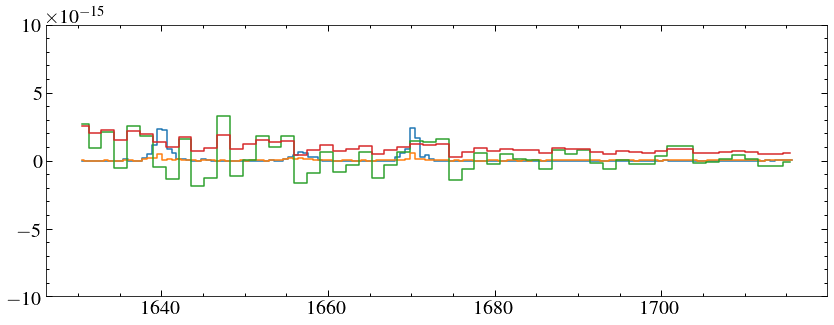

In [98]:
#w0, w1 = ndata['WAVELENGTH'][0], fdata['WAVELENGTH'][-1]
ints = []
w0, w1 = 1630, fdata['WAVELENGTH'][-1]
for i in [0,1]:
    if i == 0:
        dt = fdata
    else:
        dt = ndata
    w, f, e, dq = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ']
    mask = (w > w0) & (w < w1)# & (dq ==0)
    wi, fi, ei = w[mask], f[mask], e[mask]
    plt.step(wi, fi, where='mid')
    plt.step(wi, ei, where='mid')
    fint = np.trapz(fi, wi)
    eint = np.sum(ei[1:]**2*np.diff(wi)**2)**0.5 
    print(fint, eint)
    ints.append(fint)
plt.ylim(-0.1e-13, 0.1e-13)
print(ints[0]/ints[1])

/home/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in double_scalars
  import sys


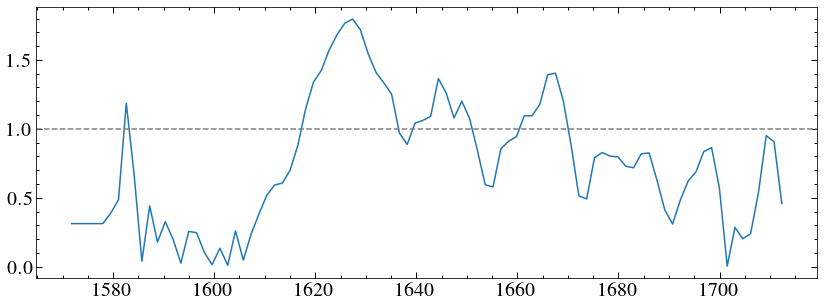

In [96]:
ratio  = []
ws = []
for i, wi in enumerate(ndata['WAVELENGTH'][::-1]):
    mask = (ndata['WAVELENGTH'] > wi) & (ndata['WAVELENGTH'] < fdata['WAVELENGTH'][-1]) 
    fint = np.trapz(ndata['FLUX'][mask], ndata['WAVELENGTH'][mask])
    eint = np.sum(ndata['ERROR'][mask][1:]**2*np.diff(ndata['WAVELENGTH'][mask])**2)**0.5
    ratio.append(abs(fint)/abs(eint))
    ws.append(wi)
plt.plot(w[::-1], ratio)
plt.axhline(1, ls='--', c='0.5')

NUV to OPT

3.748421750482594e-13 8.328968288639138e-15
1.8135300986546423e-13 3.1442910064704688e-12
2.0669200656020768


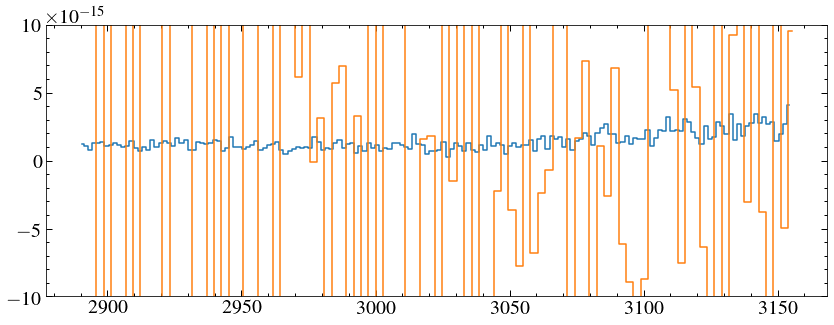

In [107]:
ints = []
w0, w1 = odata['WAVELENGTH'][0], ndata['WAVELENGTH'][-1]
for i in [0,1]:
    if i == 0:
        dt = ndata
    else:
        dt = odata
    w, f, e, dq = dt['WAVELENGTH'], dt['FLUX'], dt['ERROR'], dt['DQ']
    mask = (w > w0) & (w < w1)# & (dq ==0)
    wi, fi, ei = w[mask], f[mask], e[mask]
    plt.step(wi, fi, where='mid')
  #  plt.step(wi, ei, where='mid')
    fint = np.trapz(fi, wi)
    eint = np.sum(ei[1:]**2*np.diff(wi)**2)**0.5 
    print(fint, eint)
    ints.append(fint)
plt.ylim(-0.1e-13, 0.1e-13)
print(ints[0]/ints[1])

Ok so STIS opt is useless for normalisation. Get Phoenix model? Compare with photometery. Did we get a COS NUV spectrum? No. Need to check FUV against flare-free COS spectrum, waiting on KF.

In [113]:
"""cospath ='/home/david/work/muscles/MegaMUSCLES/GJ_699/HST/COS/'
cx1ds =  glob.glob(cospath+'*x1d.fits')
#print(cx1ds)
for x in cx1ds:
    hdr = fits.getheader(x,0)
    print(hdr['ROOTNAME'], hdr['OPT_ELEM'])"""

"cospath ='/home/david/work/muscles/MegaMUSCLES/GJ_699/HST/COS/'\ncx1ds =  glob.glob(cospath+'*x1d.fits')\n#print(cx1ds)\nfor x in cx1ds:\n    hdr = fits.getheader(x,0)\n    print(hdr['ROOTNAME'], hdr['OPT_ELEM'])"